In [1]:
# -*- coding: utf-8 -*-

import meep as mp
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

resolution = 50         # pixels/μm

dpml = 1.0              # PML thickness
dsub = 3.0              # substrate thickness
dpad = 3.0              # padding between grating and PML

wvl_min = 0.4           # min wavelength
wvl_max = 0.6           # max wavelength
fmin = 1/wvl_max        # min frequency
fmax = 1/wvl_min        # max frequency
fcen = 0.5*(fmin+fmax)  # center frequency
df = fmax-fmin          # frequency width
nfreq = 21              # number of frequency bins

k_point = mp.Vector3(0,0,0)

glass = mp.Medium(index=1.5)

def grating(gp,gh,gdc,oddz):
  sx = dpml+dsub+gh+dpad+dpml
  sy = gp

  cell_size = mp.Vector3(sx,sy,0)
  pml_layers = [mp.PML(thickness=dpml,direction=mp.X)]

  src_pt = mp.Vector3(-0.5*sx+dpml+0.5*dsub,0,0)
  sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Ez if oddz else mp.Hz, center=src_pt, size=mp.Vector3(0,sy,0))]

  symmetries=[mp.Mirror(mp.Y, phase=+1 if oddz else -1)]
  
  sim = mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=pml_layers,
                      k_point=k_point,
                      default_material=glass,
                      sources=sources,
                      symmetries=symmetries)

  mon_pt = mp.Vector3(0.5*sx-dpml-0.5*dpad,0,0)
  flux_mon = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mon_pt, size=mp.Vector3(0,sy,0)))

  sim.run(until_after_sources=100)

  input_flux = mp.get_fluxes(flux_mon)

  sim.reset_meep()

  geometry = [mp.Block(material=glass, size=mp.Vector3(dpml+dsub,mp.inf,mp.inf), center=mp.Vector3(-0.5*sx+0.5*(dpml+dsub),0,0)),
              mp.Block(material=glass, size=mp.Vector3(gh,gdc*gp,mp.inf), center=mp.Vector3(-0.5*sx+dpml+dsub+0.5*gh,0,0))]

  sim = mp.Simulation(resolution=resolution,
                      cell_size=cell_size,
                      boundary_layers=pml_layers,
                      geometry=geometry,
                      k_point=k_point,
                      sources=sources,
                      symmetries=symmetries)

  mode_mon = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mon_pt, size=mp.Vector3(0,sy,0)))

  sim.run(until_after_sources=300)

  freqs = mp.get_eigenmode_freqs(mode_mon)
  res = sim.get_eigenmode_coefficients(mode_mon, [1], eig_parity=mp.ODD_Z+mp.EVEN_Y if oddz else mp.EVEN_Z+mp.ODD_Y)
  coeffs = res.alpha

  mode_wvl = [1/freqs[nf] for nf in range(nfreq)]
  mode_tran = [abs(coeffs[0,nf,0])**2/input_flux[nf] for nf in range(nfreq)]
  mode_phase = [np.angle(coeffs[0,nf,0]) for nf in range(nfreq)]

  return mode_wvl, mode_tran, mode_phase

gp = 0.35
gh = 0.6  
gdc = np.linspace(0.1,1.0,10)
mode_tran = np.empty((gdc.size,nfreq))
mode_phase = np.empty((gdc.size,nfreq))
for n in range(gdc.size):
    mode_wvl, mode_tran[n,:], mode_phase[n,:] = grating(gp,gh,gdc[n],True)

-----------
Initializing structure...
run 0 finished at t = 112.0 (11200 timesteps)
-----------
Initializing structure...
run 0 finished at t = 312.0 (31200 timesteps)
-----------
Initializing structure...
run 0 finished at t = 112.0 (11200 timesteps)
-----------
Initializing structure...
run 0 finished at t = 312.0 (31200 timesteps)
-----------
Initializing structure...
run 0 finished at t = 112.0 (11200 timesteps)
-----------
Initializing structure...
run 0 finished at t = 312.0 (31200 timesteps)
-----------
Initializing structure...
run 0 finished at t = 112.0 (11200 timesteps)
-----------
Initializing structure...
run 0 finished at t = 312.0 (31200 timesteps)
-----------
Initializing structure...
run 0 finished at t = 112.0 (11200 timesteps)
-----------
Initializing structure...
run 0 finished at t = 312.0 (31200 timesteps)
-----------
Initializing structure...
run 0 finished at t = 112.0 (11200 timesteps)
-----------
Initializing structure...
run 0 finished at t = 312.0 (31200 tim

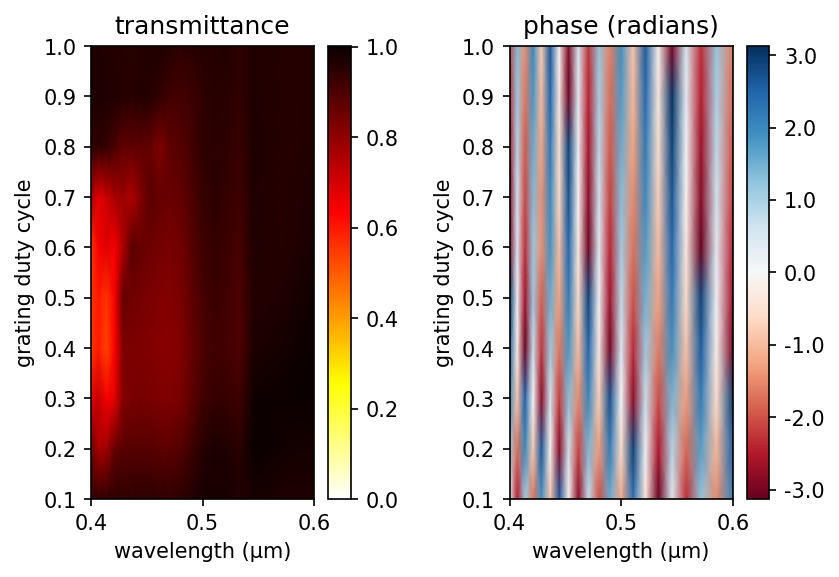

In [2]:
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.pcolormesh(mode_wvl, gdc, mode_tran, cmap='hot_r', shading='gouraud', vmin=0, vmax=mode_tran.max())
plt.axis([wvl_min, wvl_max, gdc[0], gdc[-1]])
plt.xlabel("wavelength (μm)")
plt.xticks([t for t in np.linspace(wvl_min,wvl_max,3)])
plt.ylabel("grating duty cycle")
plt.yticks([t for t in np.arange(gdc[0],gdc[-1]+0.1,0.1)])
plt.title("transmittance")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.arange(0,1.2,0.2)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.linspace(0,1,6)])

plt.subplot(1,2,2)
plt.pcolormesh(mode_wvl, gdc, mode_phase, cmap='RdBu', shading='gouraud', vmin=mode_phase.min(), vmax=mode_phase.max())
plt.axis([wvl_min, wvl_max, gdc[0], gdc[-1]])
plt.xlabel("wavelength (μm)")
plt.xticks([t for t in np.linspace(wvl_min,wvl_max,3)])
plt.ylabel("grating duty cycle")
plt.yticks([t for t in np.arange(gdc[0],gdc[-1]+0.1,0.1)])
plt.title("phase (radians)")
cbar = plt.colorbar()
cbar.set_ticks([t for t in range(-3,4)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in range(-3,4)])

plt.subplots_adjust(wspace=0.5)